In [4]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

#change positions to those of last frame of trajectory
traj = md.load('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/liquid_phase_experiments/test_benzene_full_equil_n100_100ns.h5')
benzene.positions = traj.xyz[-1]
benzene

platform = Platform.getPlatformByName('CUDA')
pmd = benzene
constrain_what_bond = app.AllBonds 
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)
temperature = 298.15 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)

state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()


In [7]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md

import openmm as mm


# Load the parameterized system from the pickle file
with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

# Load the last frame of the trajectory
traj = md.load('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/liquid_phase_experiments/test_benzene_full_equil_n100_100ns.h5')
benzene.positions = traj.xyz[-1] * unit.nanometers

# Set up the platform
platform = Platform.getPlatformByName('CUDA')

# Define constraints and create the system
constrain_what_bond = app.AllBonds 
system = benzene.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

# Get the original box vectors and extend in the z-dimension
box_vectors = system.getDefaultPeriodicBoxVectors()
extended_box_vectors = (
    box_vectors[0],
    box_vectors[1],
    mm.Vec3(box_vectors[2][0], box_vectors[2][1], box_vectors[2][2] * 3)  # Extend z-dimension by 3 times
)
system.setDefaultPeriodicBoxVectors(*extended_box_vectors)

# Center the atoms in the middle of the extended box
positions = benzene.positions
center_shift = (extended_box_vectors[2][2] - box_vectors[2][2]) / 2
for i in range(len(positions)):
    positions[i] = mm.Vec3(positions[i][0], positions[i][1], positions[i][2] + center_shift)

# Define the simulation parameters
temperature = 298.15 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
integrator = VerletIntegrator(time_step)

# Create the simulation
simulation = Simulation(benzene.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*extended_box_vectors)
simulation.context.setPositions(positions)

# Minimize energy
print('Minimizing energy...')
simulation.minimizeEnergy()

# Equilibrate in NVT ensemble
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.reporters.append(app.DCDReporter('output.dcd', 1000))
simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True))

simulation.step(100000)  # Number of equilibration steps

print('Simulation completed')


/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


AttributeError: 'Vec3' object has no attribute 'unit'

In [14]:
# Load the parameterized system from the pickle file
with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

#print out positions
benzene.save('benzene.pdb')

OSError: benzene.pdb exists; not overwriting

In [30]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 298.15 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test'
platform="CUDA"
num_steps=5000 * 500
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")



2024-07-24 14:18:34,255 - INFO - Starting simulation via OpenMM
2024-07-24 14:18:34,264 - INFO - Adding bonds...
2024-07-24 14:18:34,266 - INFO - Adding angles...
2024-07-24 14:18:34,268 - INFO - Adding dihedrals...
2024-07-24 14:18:34,272 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-24 14:18:34,273 - INFO - Adding Urey-Bradleys...
2024-07-24 14:18:34,273 - INFO - Adding improper torsions...
2024-07-24 14:18:34,273 - INFO - Adding CMAP torsions...
2024-07-24 14:18:34,274 - INFO - Adding trigonal angle terms...
2024-07-24 14:18:34,274 - INFO - Adding out-of-plane bends...
2024-07-24 14:18:34,274 - INFO - Adding pi-torsions...
2024-07-24 14:18:34,274 - INFO - Adding stretch-bends...
2024-07-24 14:18:34,274 - INFO - Adding torsion-torsions...
2024-07-24 14:18:34,275 - INFO - Adding Nonbonded force...
2024-07-24 14:18:34,315 - INFO - Adding thermostat and barostat
2024-07-24 14:18:34,856 - INFO - Energy minimized
2024-07-24 14:18:34,901 - INFO - Adding bonds...
2024-07-24 14:18:3

In [32]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 350 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test_benzene_350K'
platform="CUDA"
num_steps=5000 * 500
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")



2024-07-24 14:32:19,551 - INFO - Starting simulation via OpenMM
2024-07-24 14:32:19,560 - INFO - Adding bonds...
2024-07-24 14:32:19,561 - INFO - Adding angles...
2024-07-24 14:32:19,563 - INFO - Adding dihedrals...
2024-07-24 14:32:19,568 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-24 14:32:19,568 - INFO - Adding Urey-Bradleys...
2024-07-24 14:32:19,568 - INFO - Adding improper torsions...
2024-07-24 14:32:19,568 - INFO - Adding CMAP torsions...
2024-07-24 14:32:19,569 - INFO - Adding trigonal angle terms...
2024-07-24 14:32:19,569 - INFO - Adding out-of-plane bends...
2024-07-24 14:32:19,569 - INFO - Adding pi-torsions...
2024-07-24 14:32:19,569 - INFO - Adding stretch-bends...
2024-07-24 14:32:19,569 - INFO - Adding torsion-torsions...
2024-07-24 14:32:19,570 - INFO - Adding Nonbonded force...
2024-07-24 14:32:19,612 - INFO - Adding thermostat and barostat
2024-07-24 14:32:20,166 - INFO - Energy minimized
2024-07-24 14:32:20,206 - INFO - Adding bonds...
2024-07-24 14:32:2

In [51]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 450 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test_benzene_450K_1ns'
platform="CUDA"
num_steps=5000 * 100
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")



2024-07-24 16:10:05,982 - INFO - Starting simulation via OpenMM
2024-07-24 16:10:05,993 - INFO - Adding bonds...
2024-07-24 16:10:05,995 - INFO - Adding angles...
2024-07-24 16:10:05,998 - INFO - Adding dihedrals...
2024-07-24 16:10:06,003 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-24 16:10:06,003 - INFO - Adding Urey-Bradleys...
2024-07-24 16:10:06,003 - INFO - Adding improper torsions...
2024-07-24 16:10:06,003 - INFO - Adding CMAP torsions...
2024-07-24 16:10:06,004 - INFO - Adding trigonal angle terms...
2024-07-24 16:10:06,004 - INFO - Adding out-of-plane bends...
2024-07-24 16:10:06,004 - INFO - Adding pi-torsions...
2024-07-24 16:10:06,005 - INFO - Adding stretch-bends...
2024-07-24 16:10:06,005 - INFO - Adding torsion-torsions...
2024-07-24 16:10:06,005 - INFO - Adding Nonbonded force...
2024-07-24 16:10:06,046 - INFO - Adding thermostat and barostat
2024-07-24 16:10:06,815 - INFO - Energy minimized
2024-07-24 16:10:06,856 - INFO - Adding bonds...
2024-07-24 16:10:0

In [16]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 450 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test_benzene_450K_5ns'
platform="CUDA"
num_steps=5000 * 500
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")



2024-07-26 10:15:27,759 - INFO - Starting simulation via OpenMM
2024-07-26 10:15:27,774 - INFO - Adding bonds...
2024-07-26 10:15:27,777 - INFO - Adding angles...
2024-07-26 10:15:27,781 - INFO - Adding dihedrals...
2024-07-26 10:15:27,790 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-26 10:15:27,791 - INFO - Adding Urey-Bradleys...
2024-07-26 10:15:27,791 - INFO - Adding improper torsions...
2024-07-26 10:15:27,791 - INFO - Adding CMAP torsions...
2024-07-26 10:15:27,791 - INFO - Adding trigonal angle terms...
2024-07-26 10:15:27,792 - INFO - Adding out-of-plane bends...
2024-07-26 10:15:27,792 - INFO - Adding pi-torsions...
2024-07-26 10:15:27,792 - INFO - Adding stretch-bends...
2024-07-26 10:15:27,792 - INFO - Adding torsion-torsions...
2024-07-26 10:15:27,793 - INFO - Adding Nonbonded force...
2024-07-26 10:15:27,836 - INFO - Adding thermostat and barostat
2024-07-26 10:15:28,596 - INFO - Energy minimized
2024-07-26 10:15:28,638 - INFO - Adding bonds...
2024-07-26 10:15:2

In [2]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md
from copy import deepcopy   

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 450 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test_benzene_450K_1ns_huge_box'
platform="CUDA"
num_steps=5000 * 100
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 50
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")



2024-07-26 09:55:52,833 - INFO - Starting simulation via OpenMM
2024-07-26 09:55:52,842 - INFO - Adding bonds...
2024-07-26 09:55:52,844 - INFO - Adding angles...
2024-07-26 09:55:52,846 - INFO - Adding dihedrals...
2024-07-26 09:55:52,851 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-26 09:55:52,851 - INFO - Adding Urey-Bradleys...
2024-07-26 09:55:52,851 - INFO - Adding improper torsions...
2024-07-26 09:55:52,852 - INFO - Adding CMAP torsions...
2024-07-26 09:55:52,852 - INFO - Adding trigonal angle terms...
2024-07-26 09:55:52,852 - INFO - Adding out-of-plane bends...
2024-07-26 09:55:52,852 - INFO - Adding pi-torsions...
2024-07-26 09:55:52,852 - INFO - Adding stretch-bends...
2024-07-26 09:55:52,853 - INFO - Adding torsion-torsions...
2024-07-26 09:55:52,853 - INFO - Adding Nonbonded force...
2024-07-26 09:55:52,896 - INFO - Adding thermostat and barostat
2024-07-26 09:55:53,508 - INFO - Energy minimized
2024-07-26 09:55:53,546 - INFO - Adding bonds...
2024-07-26 09:55:5

In [34]:

import mdtraj as md
#load trajectory
traj = md.load('test_benzene_450K_5ns.h5')
#save as dcd
traj.save('test_benzene_450K_5ns.dcd')
traj.save('test_benzene_450K.h5')

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [3]:
import mdtraj as md
#load trajectory
traj = md.load('test_benzene_450K_1ns_huge_box.h5')
#save as dcd
traj.save('test_benzene_450K_1ns_huge_box.dcd')

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [4]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md
from copy import deepcopy   

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 450 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test_benzene_450K_1ns_extend_all_directions'
platform="CUDA"
num_steps=5000 * 100
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy_box[1] = pmd_copy_box[1] * 5
pmd_copy_box[0] = pmd_copy_box[0] * 5
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")



2024-07-26 09:59:35,262 - INFO - Starting simulation via OpenMM
2024-07-26 09:59:35,270 - INFO - Adding bonds...
2024-07-26 09:59:35,272 - INFO - Adding angles...
2024-07-26 09:59:35,274 - INFO - Adding dihedrals...
2024-07-26 09:59:35,279 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-26 09:59:35,279 - INFO - Adding Urey-Bradleys...
2024-07-26 09:59:35,279 - INFO - Adding improper torsions...
2024-07-26 09:59:35,279 - INFO - Adding CMAP torsions...
2024-07-26 09:59:35,280 - INFO - Adding trigonal angle terms...
2024-07-26 09:59:35,281 - INFO - Adding out-of-plane bends...
2024-07-26 09:59:35,281 - INFO - Adding pi-torsions...
2024-07-26 09:59:35,281 - INFO - Adding stretch-bends...
2024-07-26 09:59:35,281 - INFO - Adding torsion-torsions...
2024-07-26 09:59:35,282 - INFO - Adding Nonbonded force...
2024-07-26 09:59:35,330 - INFO - Adding thermostat and barostat
2024-07-26 09:59:35,875 - INFO - Energy minimized
2024-07-26 09:59:35,914 - INFO - Adding bonds...
2024-07-26 09:59:3

In [5]:
import mdtraj as md
#load trajectory
traj = md.load('test_benzene_450K_1ns_extend_all_directions.h5')
#save as dcd
traj.save('test_benzene_450K_1ns_extend_all_directions.dcd')

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [53]:
import mdtraj as md
#load trajectory
traj = md.load('test_benzene_450K_1ns.h5')
#save as dcd
traj.save('test_benzene_450K_1ns.dcd')

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [33]:
import mdtraj as md
#load trajectory
traj = md.load('test_benzene_350K.h5')
#save as dcd
traj.save('test_benzene_350K.dcd')

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [31]:
import mdtraj as md
#load trajectory
traj = md.load('test.h5')
#save as dcd
traj.save('test.dcd')

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [23]:
from copy import deepcopy   
pmd_copy = deepcopy(pmd)

In [25]:
pmd_copy.box

array([28.291, 28.291, 28.291, 90.   , 90.   , 90.   ])

In [26]:
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy.box = pmd_copy_box
pmd_copy.box

array([ 28.291,  28.291, 141.455,  90.   ,  90.   ,  90.   ])

In [45]:
#calculate how much space my molecules would occupy if all in gas phase
n_mols = 256
avogradros_number = 6.02214076e23
mol_vol = 22.4e-3 #m^3

mol_vol_per_mol = mol_vol / avogradros_number

total_vol = n_mols * mol_vol_per_mol

total_vol

#convert to nm^3
total_vol_nm3 = total_vol * 1e27
print(total_vol_nm3)

current_vol_a3 = pmd_copy.box[0] * pmd_copy.box[1] * pmd_copy.box[2] #in armstrongs

current_vol_nm3 = current_vol_a3 * 1e-3
print(current_vol_nm3)

9522.195226801707
113.21784923085504


In [39]:
pmd.box_vectors

Quantity(value=([28.291000000000004, 0.0, 0.0], [0, 28.291000000000004, 0.0], [0, 0, 28.291000000000004]), unit=angstrom)

In [49]:
current_vol_a3  / 22.4*256/6.02214076e23 * 1e27  

2148601848.5626655

In [50]:
150*25*25

93750

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


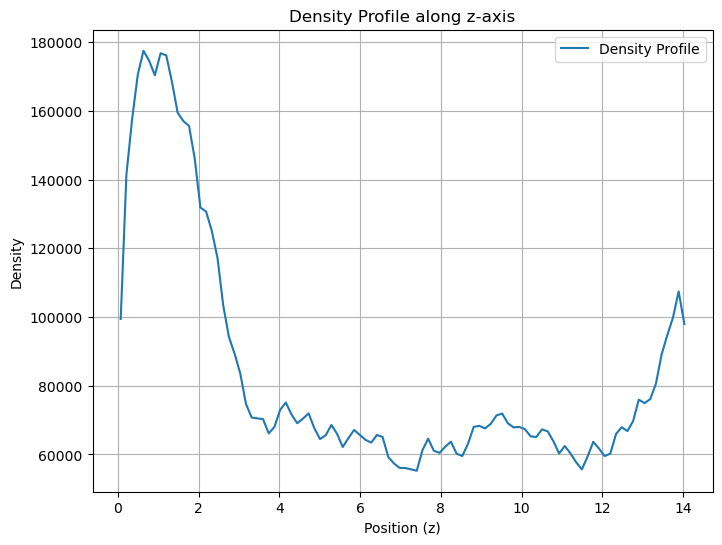

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Example function to calculate density profile
def calculate_density_profile(trajectory, box_length, n_bins, axis=2):
    """
    Calculate the density profile along a given axis.

    Parameters:
    trajectory : numpy.ndarray
        Array of shape (n_frames, n_particles, 3) containing particle positions.
    box_length : float
        Length of the simulation box along the axis of interest.
    n_bins : int
        Number of bins to divide the box length into.
    axis : int
        Axis along which to calculate the density profile (0: x, 1: y, 2: z).

    Returns:
    bin_centers : numpy.ndarray
        Centers of the bins.
    density : numpy.ndarray
        Density values for each bin.
    """
    # Get the positions along the specified axis
    positions = trajectory[:, :, axis].flatten()
    
    # Create histogram
    hist, bin_edges = np.histogram(positions, bins=n_bins, range=(0, box_length))
    
    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate volume of each bin (assuming unit cross-sectional area)
    bin_volume = box_length / n_bins
    
    # Calculate density
    density = hist / bin_volume
    
    return bin_centers, density

# Example data
# trajectory: shape (n_frames, n_particles, 3)
# This is a mock trajectory data for illustration.
box_length = 14.1
n_bins = 100
trajectory = md.load('test_benzene_450K_1ns.h5').xyz

# Calculate density profile along the z-axis
bin_centers, density = calculate_density_profile(trajectory, box_length, n_bins, axis=2)

# Plotting the density profile
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, density, label='Density Profile')
plt.xlabel('Position (z)')
plt.ylabel('Density')
plt.title('Density Profile along z-axis')
plt.legend()
plt.grid(True)
plt.show()


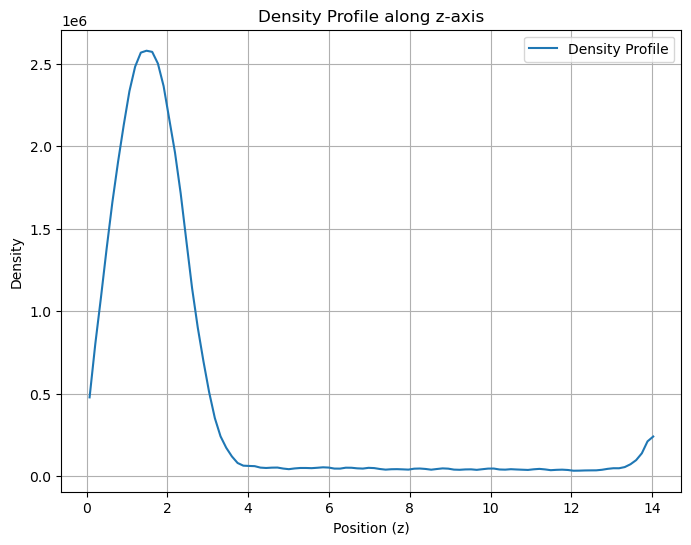

In [13]:
trajectory = md.load('test_benzene_350K.h5').xyz

# Calculate density profile along the z-axis
bin_centers, density = calculate_density_profile(trajectory, box_length, n_bins, axis=2)

# Plotting the density profile
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, density, label='Density Profile')
plt.xlabel('Position (z)')
plt.ylabel('Density')
plt.title('Density Profile along z-axis')
plt.legend()
plt.grid(True)
plt.show()


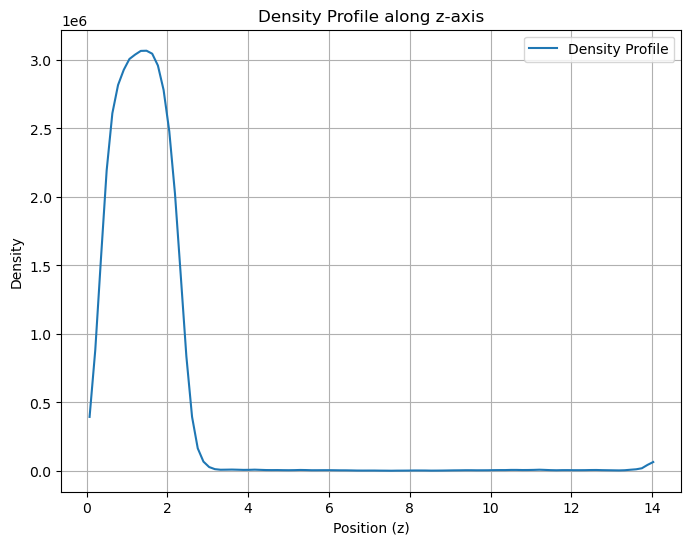

In [15]:
trajectory = md.load('test.h5').xyz

# Calculate density profile along the z-axis
bin_centers, density = calculate_density_profile(trajectory, box_length, n_bins, axis=2)

# Plotting the density profile
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, density, label='Density Profile')
plt.xlabel('Position (z)')
plt.ylabel('Density')
plt.title('Density Profile along z-axis')
plt.legend()
plt.grid(True)
plt.show()


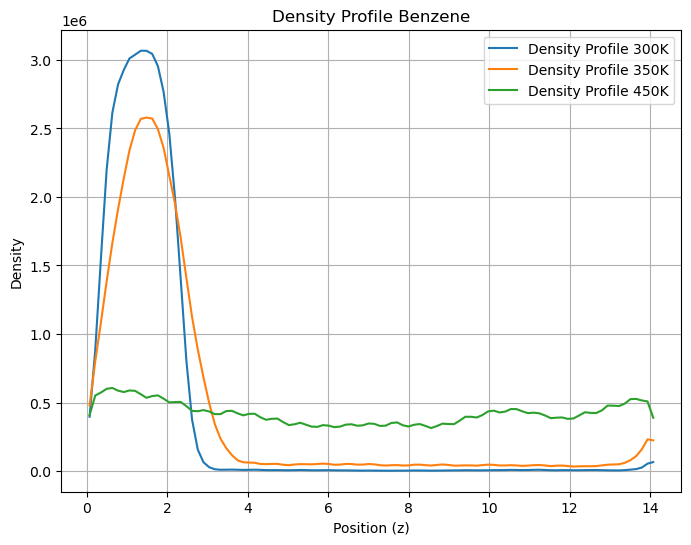

In [22]:
#plot from traj test.h5, test_benzene_350K ande test_benzene_450K in one plot

box_length =  141.455 / 10
trajectory_RT = md.load('test.h5').xyz
trajectory_350K = md.load('test_benzene_350K.h5').xyz
trajectory_450K = md.load('test_benzene_450K_5ns.h5').xyz

# Calculate density profile along the z-axis
bin_centers_RT, density_RT = calculate_density_profile(trajectory_RT, box_length, n_bins, axis=2)
bin_centers_350K, density_350K = calculate_density_profile(trajectory_350K, box_length, n_bins, axis=2)
bin_centers_450K, density_450K = calculate_density_profile(trajectory_450K, box_length, n_bins, axis=2)

# Plotting the density profile
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_RT, density_RT, label='Density Profile 300K')
plt.plot(bin_centers_350K, density_350K, label='Density Profile 350K')
plt.plot(bin_centers_450K, density_450K, label='Density Profile 450K')
plt.xlabel('Position (z)')
plt.ylabel('Density')
plt.title('Density Profile Benzene')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
trajectory_450K

array([[[1.0688225 , 1.0933086 , 0.47124332],
        [1.1763937 , 1.0428452 , 0.5442274 ],
        [1.2798706 , 1.1277875 , 0.58324194],
        ...,
        [0.88121814, 1.5306748 , 2.6976197 ],
        [1.0748087 , 1.6692849 , 2.6591911 ],
        [1.21183   , 1.6387241 , 2.451964  ]],

       [[1.2052929 , 0.8617988 , 0.34328455],
        [1.2861444 , 0.8253405 , 0.4508886 ],
        [1.3158642 , 0.91985446, 0.5490143 ],
        ...,
        [1.0540704 , 1.3721784 , 2.7037401 ],
        [1.2611293 , 1.4797622 , 2.5619426 ],
        [1.2489462 , 1.483014  , 2.3302932 ]],

       [[1.2366258 , 0.77287865, 0.3783616 ],
        [1.2976428 , 0.82906586, 0.49045405],
        [1.3199295 , 0.96665394, 0.49465147],
        ...,
        [1.1566964 , 1.4182873 , 2.7454379 ],
        [1.2845654 , 1.5658591 , 2.5882053 ],
        [1.242965  , 1.5744321 , 2.3589578 ]],

       ...,

       [[1.3503966 , 0.48304355, 5.6838923 ],
        [1.2767059 , 0.47197735, 5.566028  ],
        [1.3307623 , 0

[2.56219577e+05 5.74065003e+05 1.00813370e+06 1.42485338e+06
 1.69381571e+06 1.82698047e+06 1.89513109e+06 1.94984755e+06
 1.96770939e+06 1.98638625e+06 1.98598331e+06 1.97138157e+06
 1.91358359e+06 1.79221835e+06 1.59502845e+06 1.29243953e+06
 9.08975556e+05 5.22457532e+05 2.42954840e+05 1.01662734e+05
 4.15707770e+04 1.80175138e+04 8.21891669e+03 6.02110053e+03
 6.38740322e+03 6.75828470e+03 6.09893985e+03 5.21523460e+03
 5.69142810e+03 6.30956390e+03 5.48080406e+03 4.41852624e+03
 4.34984449e+03 4.40478989e+03 3.98354179e+03 3.82786315e+03
 4.18042949e+03 4.99087420e+03 4.45515651e+03 3.60808153e+03
 3.70423599e+03 3.96522666e+03 3.97896301e+03 3.51192708e+03
 3.18683344e+03 3.09983655e+03 2.74269142e+03 2.22986765e+03
 1.97803455e+03 2.28023427e+03 2.13829197e+03 1.82235590e+03
 1.55220766e+03 1.44689564e+03 1.88188009e+03 1.79488320e+03
 2.10624049e+03 2.64653696e+03 2.53206737e+03 2.24818278e+03
 1.77656806e+03 2.02840117e+03 2.37638873e+03 2.81137317e+03
 3.13646682e+03 3.223463

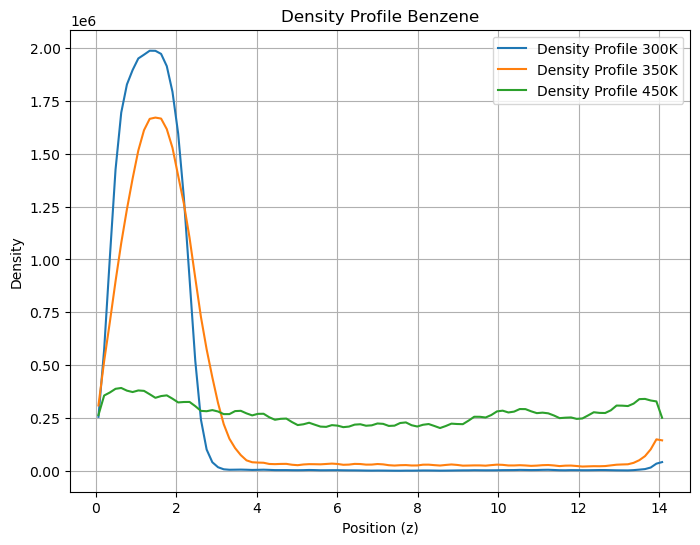

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Example function to calculate physical density profile
def calculate_physical_density_profile(trajectory, box_length, n_bins, molecular_weight, axis=2):
    """
    Calculate the physical density profile along a given axis.

    Parameters:
    trajectory : numpy.ndarray
        Array of shape (n_frames, n_particles, 3) containing particle positions.
    box_length : float
        Length of the simulation box along the axis of interest in Angstroms.
    n_bins : int
        Number of bins to divide the box length into.
    molecular_weight : float
        Molecular weight of the molecule in grams per mole (g/mol).
    axis : int
        Axis along which to calculate the density profile (0: x, 1: y, 2: z).

    Returns:
    bin_centers : numpy.ndarray
        Centers of the bins in Angstroms.
    density : numpy.ndarray
        Physical density values for each bin in g/cm³.
    """
    # Avogadro's number (particles per mole)
    avogadro_number = 6.02214076e23
    
    # Convert molecular weight to mass of one molecule in grams
    mass_per_molecule = molecular_weight / avogadro_number
    
    # Get the positions along the specified axis
    positions = trajectory[:, :, axis].flatten()
    
    # Create histogram
    hist, bin_edges = np.histogram(positions, bins=n_bins, range=(0, box_length))
    
    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate bin volume in cubic centimeters (assuming 1 Å = 1e-8 cm)
    bin_volume = (box_length / n_bins) * (box_length * 1e-8)**2 * 1e-8
    
    # Calculate density in g/cm³
    density = (hist * mass_per_molecule) / bin_volume
    
    return bin_centers, density
from rdkit import Chem
from rdkit.Chem import Descriptors
smiles_benze = 'c1ccccc1'
benzene = Chem.MolFromSmiles(smiles_benze)
molecular_weight = Descriptors.ExactMolWt(benzene)
# Example data
n_bins = 100
bin_centers_RT, density_RT = calculate_physical_density_profile(trajectory_RT, box_length, n_bins, molecular_weight, axis=2)
bin_centers_350K, density_350K = calculate_physical_density_profile(trajectory_350K, box_length, n_bins, molecular_weight, axis=2)
bin_centers_450K, density_450K = calculate_physical_density_profile(trajectory_450K, box_length, n_bins, molecular_weight, axis=2)
print(density_RT)
# Plotting the density profile
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_RT, density_RT, label='Density Profile 300K')
plt.plot(bin_centers_350K, density_350K, label='Density Profile 350K')
plt.plot(bin_centers_450K, density_450K, label='Density Profile 450K')
plt.xlabel('Position (z)')
plt.ylabel('Density')
plt.title('Density Profile Benzene')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#convertr 1.9768000911620216 in log mmHg to log Pa
vp_log_mmhg = 1.9768000911620216
vp_mmhg = 10**vp_log_mmhg
vp_pa = vp_mmhg * 133.322
vp_log_pa = np.log10(vp_pa)
print(vp_log_pa)

4.101701911170382


In [35]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md
from copy import deepcopy   

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 450 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test_benzene_450K_NPT_test'
platform="CUDA"
num_steps=5000 * 100
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
#add barostat
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")



2024-07-26 15:03:18,411 - INFO - Starting simulation via OpenMM
2024-07-26 15:03:18,420 - INFO - Adding bonds...
2024-07-26 15:03:18,422 - INFO - Adding angles...
2024-07-26 15:03:18,425 - INFO - Adding dihedrals...
2024-07-26 15:03:18,429 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-26 15:03:18,430 - INFO - Adding Urey-Bradleys...
2024-07-26 15:03:18,430 - INFO - Adding improper torsions...
2024-07-26 15:03:18,430 - INFO - Adding CMAP torsions...
2024-07-26 15:03:18,430 - INFO - Adding trigonal angle terms...
2024-07-26 15:03:18,431 - INFO - Adding out-of-plane bends...
2024-07-26 15:03:18,431 - INFO - Adding pi-torsions...
2024-07-26 15:03:18,431 - INFO - Adding stretch-bends...
2024-07-26 15:03:18,431 - INFO - Adding torsion-torsions...
2024-07-26 15:03:18,432 - INFO - Adding Nonbonded force...
2024-07-26 15:03:18,473 - INFO - Adding thermostat and barostat
2024-07-26 15:03:19,436 - INFO - Energy minimized
2024-07-26 15:03:19,478 - INFO - Adding bonds...
2024-07-26 15:03:1

In [36]:
traj = md.load('test_benzene_450K_NPT_test.h5')
#save as dcd
traj.save('test_benzene_450K_NPT_test.dcd')


/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [37]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md
from copy import deepcopy   

with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


temperature = 298.15 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path="."
file_name = 'test_benzene_298K_NPT_test'
platform="CUDA"
num_steps=5000 * 100
write_out_freq=500
report_equilibration=True
report_production=True
constrain_all_bonds=True

                   
logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat and barostat")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")


state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

# Production
del system
del simulation

system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
#add barostat
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)
system.addForce(thermostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

pmd_copy = deepcopy(pmd)
pmd_copy_box = pmd_copy.box
pmd_copy_box[2] = pmd_copy_box[2] * 5
pmd_copy.box = pmd_copy_box

simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)
logger.info("Production complete")

traj = md.load('test_benzene_298K_NPT_test.h5')
#save as dcd
traj.save('test_benzene_298K_NPT_test.dcd')



2024-07-26 15:06:10,375 - INFO - Starting simulation via OpenMM
2024-07-26 15:06:10,384 - INFO - Adding bonds...
2024-07-26 15:06:10,386 - INFO - Adding angles...
2024-07-26 15:06:10,388 - INFO - Adding dihedrals...
2024-07-26 15:06:10,393 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-26 15:06:10,393 - INFO - Adding Urey-Bradleys...
2024-07-26 15:06:10,394 - INFO - Adding improper torsions...
2024-07-26 15:06:10,394 - INFO - Adding CMAP torsions...
2024-07-26 15:06:10,394 - INFO - Adding trigonal angle terms...
2024-07-26 15:06:10,394 - INFO - Adding out-of-plane bends...
2024-07-26 15:06:10,395 - INFO - Adding pi-torsions...
2024-07-26 15:06:10,395 - INFO - Adding stretch-bends...
2024-07-26 15:06:10,395 - INFO - Adding torsion-torsions...
2024-07-26 15:06:10,395 - INFO - Adding Nonbonded force...
2024-07-26 15:06:10,453 - INFO - Adding thermostat and barostat
2024-07-26 15:06:11,014 - INFO - Energy minimized
2024-07-26 15:06:11,054 - INFO - Adding bonds...
2024-07-26 15:06:1

OpenMMException: The periodic box size has decreased to less than twice the nonbonded cutoff.

In [38]:
traj = md.load('test_benzene_298K_NPT_test.h5')
#save as dcd
traj.save('test_benzene_298K_NPT_test.dcd')


/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [42]:


with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)

parmed_obj = benzene

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

temperature = 298.15 * unit.kelvin
pressure = 1.013 * unit.bar
time_step = 0.002 * unit.picoseconds
equil_steps = 50000  # 100 ps

file_path = "."
file_name = 'test_benzene_298K_nvt_npt_test2'
platform_name = "CUDA"
num_steps = 5000 * 100
write_out_freq = 500
report_equilibration = True
report_production = True
constrain_all_bonds = True

logger.info("Starting simulation via OpenMM")
platform = Platform.getPlatformByName(platform_name)
pmd = parmed_obj
path = '{}/{}.h5'.format(file_path, file_name)

constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

logger.info("Adding thermostat for NVT simulation")
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
system.addForce(thermostat)
integrator = VerletIntegrator(time_step)

simulation = Simulation(pmd.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.minimizeEnergy()
logger.info("Energy minimized")

logger.info("Starting NVT equilibration")
simulation.reporters.append(StateDataReporter("{}/nvt_{}.dat".format(file_path, file_name), write_out_freq, step=True, potentialEnergy=True, temperature=True, density=True, kineticEnergy=True, totalEnergy=True, volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)

# Save the state
state = simulation.context.getState(getPositions=True, getVelocities=True, getPeriodicBoxVectors=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

del system
del simulation

logger.info("Setting up system for NPT simulation")
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(thermostat)
system.addForce(barostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.context.setVelocities(pmd.velocities)

logger.info("Starting NPT production run")
simulation.reporters.append(StateDataReporter("{}/npt_{}.dat".format(file_path, file_name), write_out_freq, step=True, potentialEnergy=True, temperature=True, density=True, kineticEnergy=True, totalEnergy=True, volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)

logger.info("Production complete")

traj = md.load('test_benzene_298K_nvt_npt_test2.h5')
#save as dcd
traj.save('test_benzene_298K_nvt_npt_test2.dcd')


Exception ignored in: <function _BaseReporter.__del__ at 0x7f9cdc5d8cc0>
Traceback (most recent call last):
  File "/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/reporters/basereporter.py", line 275, in __del__
    self.close()
  File "/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/reporters/basereporter.py", line 279, in close
    self._traj_file.close()
    ^^^^^^^^^^^^^^^
AttributeError: 'HDF5Reporter' object has no attribute '_traj_file'
2024-07-26 15:13:43,531 - INFO - Starting simulation via OpenMM
2024-07-26 15:13:43,540 - INFO - Adding bonds...
2024-07-26 15:13:43,542 - INFO - Adding angles...
2024-07-26 15:13:43,544 - INFO - Adding dihedrals...
2024-07-26 15:13:43,549 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-26 15:13:43,550 - INFO - Adding Urey-Bradleys...
2024-07-26 15:13:43,550 - INFO - Adding improper torsions...
2024-07-26 15:13:43,550 - INFO - Adding CMAP torsions.

TypeError: Context.getState() got an unexpected keyword argument 'getPeriodicBoxVectors'

In [43]:
# Save the state
state = simulation.context.getState(getPositions=True, getVelocities=True)
pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

del system
del simulation

logger.info("Setting up system for NPT simulation")
system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(thermostat)
system.addForce(barostat)

integrator = VerletIntegrator(time_step)
simulation = Simulation(pmd.topology, system, integrator, platform)

simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
simulation.context.setPositions(pmd.positions)
simulation.context.setVelocities(pmd.velocities)

logger.info("Starting NPT production run")
simulation.reporters.append(StateDataReporter("{}/npt_{}.dat".format(file_path, file_name), write_out_freq, step=True, potentialEnergy=True, temperature=True, density=True, kineticEnergy=True, totalEnergy=True, volume=True))
simulation.reporters.append(HDF5Reporter(path, write_out_freq))
simulation.step(num_steps)

logger.info("Production complete")

traj = md.load('test_benzene_298K_nvt_npt_test2.h5')
#save as dcd
traj.save('test_benzene_298K_nvt_npt_test2.dcd')

2024-07-26 15:18:46,846 - INFO - Setting up system for NPT simulation
2024-07-26 15:18:46,851 - INFO - Adding bonds...
2024-07-26 15:18:46,853 - INFO - Adding angles...
2024-07-26 15:18:46,855 - INFO - Adding dihedrals...
2024-07-26 15:18:46,860 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-26 15:18:46,861 - INFO - Adding Urey-Bradleys...
2024-07-26 15:18:46,861 - INFO - Adding improper torsions...
2024-07-26 15:18:46,861 - INFO - Adding CMAP torsions...
2024-07-26 15:18:46,861 - INFO - Adding trigonal angle terms...
2024-07-26 15:18:46,862 - INFO - Adding out-of-plane bends...
2024-07-26 15:18:46,862 - INFO - Adding pi-torsions...
2024-07-26 15:18:46,862 - INFO - Adding stretch-bends...
2024-07-26 15:18:46,863 - INFO - Adding torsion-torsions...
2024-07-26 15:18:46,863 - INFO - Adding Nonbonded force...
2024-07-26 15:18:47,010 - INFO - Starting NPT production run


OpenMMException: Particle coordinate is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

In [ ]:
traj = md.load('test_benzene_298K_nvt_npt_test2.h5')
#save as dcd
traj.save('test_benzene_298K_nvt_npt_test2.dcd')
